# Flight Delay Analysis - Random Forest Model Training

## Phase 4: Building and Evaluating Random Forest Models

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Import Random Forest model functions
from src.models.random_forest import (
    load_engineered_data,
    prepare_data_for_modeling,
    train_random_forest_regressor,
    train_random_forest_classifier,
    evaluate_regressor,
    evaluate_classifier,
    get_feature_importance,
    save_model,
    load_model
)

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

In [2]:
# Reload external files
%load_ext autoreload
%autoreload 2

---
## Part 1: Load Engineered Data
---

In [3]:
# Load the engineered dataset
input_path = '../data/processed/flight_delays_engineered.csv'
df = load_engineered_data(input_path)

print(f"\nDataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()


Dataset shape: (1527160, 19)

First few rows:


,Date (YYYY-MM-DD),Scheduled Elapsed Time (Minutes),IsWeekend,Is_Holiday_Period,Carrier_9E,Carrier_AA,Carrier_AS,Carrier_DL,Carrier_EV,Carrier_MQ,Carrier_NK,Carrier_OO,Carrier_UA,Carrier_WN,Carrier_YX,Origin_Airport_Encoded,Season_Encoded,Arrival Delay (Minutes),Is_Delayed
0,2019-01-01,83,0,1,1,0,0,0,0,0,0,0,0,0,0,67,3,-1,0
1,2019-01-01,72,0,1,1,0,0,0,0,0,0,0,0,0,0,163,3,-14,0
2,2019-01-01,85,0,1,1,0,0,0,0,0,0,0,0,0,0,86,3,9,0
3,2019-01-01,112,0,1,1,0,0,0,0,0,0,0,0,0,0,16,3,-7,0
4,2019-01-01,129,0,1,1,0,0,0,0,0,0,0,0,0,0,28,3,-32,0


In [4]:
# Define features for modeling
# Exclude non-predictive columns and the target variables
exclude_cols = ['Date (YYYY-MM-DD)', 'Carrier Code', 'Origin Airport', 
                'Season', 'Arrival Delay (Minutes)', 'Is_Delayed']

feature_cols = [col for col in df.columns if col not in exclude_cols]

print(f"\nTotal features for modeling: {len(feature_cols)}")
print(f"\nFeature list:")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i:2}. {col}")


Total features for modeling: 16

Feature list:
   1. Scheduled Elapsed Time (Minutes)
   2. IsWeekend
   3. Is_Holiday_Period
   4. Carrier_9E
   5. Carrier_AA
   6. Carrier_AS
   7. Carrier_DL
   8. Carrier_EV
   9. Carrier_MQ
  10. Carrier_NK
  11. Carrier_OO
  12. Carrier_UA
  13. Carrier_WN
  14. Carrier_YX
  15. Origin_Airport_Encoded
  16. Season_Encoded



CLASS DISTRIBUTION ANALYSIS

Is_Delayed Distribution:
  Class 0 (On-time):  1,294,299 (84.75%)
  Class 1 (Delayed):  232,861 (15.25%)
  Imbalance ratio: 5.56:1


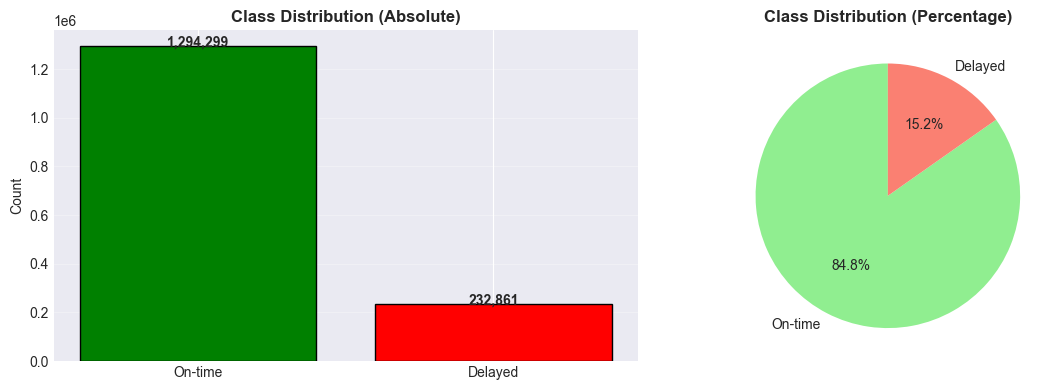

In [ ]:
print("CLASS DISTRIBUTION ANALYSIS:")

# For classification
delayed_counts = df['Is_Delayed'].value_counts()
delayed_pct = df['Is_Delayed'].value_counts(normalize=True) * 100

print("\nIs_Delayed Distribution:")
print(f"  Class 0 (On-time):  {delayed_counts[0]:,} ({delayed_pct[0]:.2f}%)")
print(f"  Class 1 (Delayed):  {delayed_counts[1]:,} ({delayed_pct[1]:.2f}%)")
print(f"  Imbalance ratio: {delayed_counts[0] / delayed_counts[1]:.2f}:1")

# Visualize
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Bar chart
axes[0].bar(['On-time', 'Delayed'], delayed_counts.values, color=['green', 'red'], edgecolor='black')
axes[0].set_ylabel('Count')
axes[0].set_title('Class Distribution (Absolute)', fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(delayed_counts.values):
    axes[0].text(i, v + 100, f'{v:,}', ha='center', fontweight='bold')

# Pie chart
axes[1].pie(delayed_counts.values, labels=['On-time', 'Delayed'], autopct='%1.1f%%', 
            colors=['lightgreen', 'salmon'], startangle=90)
axes[1].set_title('Class Distribution (Percentage)', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)

---
## Part 2: Classification Task - Predicting Delay vs On-time
---

### 2.1 Prepare Data for Classification

In [6]:
# Target: Is_Delayed (binary: 0=on-time, 1=delayed)
target_classification = 'Is_Delayed'

X_train_clf, X_test_clf, y_train_clf, y_test_clf = prepare_data_for_modeling(
    df=df,
    feature_cols=feature_cols,
    target_col=target_classification,
    test_size=0.2,
    random_state=42
)

print(f"\nTarget distribution (training set):")
print(y_train_clf.value_counts())
print(f"\nClass balance:")
print(y_train_clf.value_counts(normalize=True))

  Training set: 1,221,728 samples
  Test set: 305,432 samples
  Feature dimensions: 16

Target distribution (training set):
Is_Delayed
0    1035253
1     186475
Name: count, dtype: int64

Class balance:
Is_Delayed
0    0.847368
1    0.152632
Name: proportion, dtype: float64


### 2.2a Train Random Forest Classifier (Without Class Imbalance)

In [7]:
# Train the model
rf_classifier = train_random_forest_classifier(
    X_train=X_train_clf,
    y_train=y_train_clf,
    n_estimators=50,
    max_depth=20,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1,
    verbose=0
)


TRAINING RANDOM FOREST CLASSIFIER

Model parameters:
  - n_estimators: 50
  - max_depth: 20
  - min_samples_split: 20
  - min_samples_leaf: 10
  - class_weight: None
  - random_state: 42

✓ Training complete in 6.57 seconds

✓ Training complete in 6.57 seconds


### 2.2b Train Balanced Random Forest Classifier (with class_weight)

### 2.2c Hyperparameter Tuning (RandomizedSearchCV)
A lightweight parameter search to find better Random Forest settings (optimizing F1).

In [ ]:
# With class imbalance
rf_classifier_balanced = train_random_forest_classifier(
    X_train=X_train_clf,
    y_train=y_train_clf,
    n_estimators=50,
    max_depth=20,
    min_samples_split=20,
    min_samples_leaf=10,
    class_weight='balanced', 
    random_state=42,
    n_jobs=-1,
    verbose=0
)


TRAINING RANDOM FOREST CLASSIFIER

Model parameters:
  - n_estimators: 50
  - max_depth: 20
  - min_samples_split: 20
  - min_samples_leaf: 10
  - class_weight: balanced
  - random_state: 42

✓ Training complete in 7.48 seconds

✓ Training complete in 7.48 seconds


In [ ]:
# Trying hyperparameter tuning using RandomizedSearchCV 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

param_distributions = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 10],
    'max_features': ['sqrt', 'log2', None],
    'class_weight': [None, 'balanced']
}

base_model = RandomForestClassifier(random_state=42, n_jobs=-1)
search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_distributions,
    n_iter=20,
    scoring='f1',
    n_jobs=-1,
    cv=3,
    verbose=2,
    random_state=42
)

print("HYPERPARAMETER TUNING: RandomizedSearchCV (F1 scoring)")
search.fit(X_train_clf, y_train_clf)
print("Best params:", search.best_params_)
print(f"Best CV F1: {search.best_score_:.4f}")

rf_classifier_tuned = search.best_estimator_

# Evaluate tuned model
clf_metrics_tuned = evaluate_classifier(
    model=rf_classifier_tuned,
    X_train=X_train_clf,
    y_train=y_train_clf,
    X_test=X_test_clf,
    y_test=y_test_clf
)


HYPERPARAMETER TUNING: RandomizedSearchCV (F1 scoring)
Best params: {'n_estimators': 200, 'min_samples_split': 20, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 20, 'class_weight': 'balanced'}
Best CV F1: 0.3113

CLASSIFICATION MODEL EVALUATION
Best params: {'n_estimators': 200, 'min_samples_split': 20, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 20, 'class_weight': 'balanced'}
Best CV F1: 0.3113

CLASSIFICATION MODEL EVALUATION

Training Set Performance:
  Accuracy:  0.6564
  Precision: 0.2504
  Recall:    0.6278
  F1-Score:  0.3580

Test Set Performance:
  Accuracy:  0.6326
  Precision: 0.2184
  Recall:    0.5502
  F1-Score:  0.3126
  ROC-AUC:   0.6367

Confusion Matrix (Test Set):
[[167693  91353]
 [ 20865  25521]]

Classification Report (Test Set):
              precision    recall  f1-score   support

     On-time       0.89      0.65      0.75    259046
     Delayed       0.22      0.55      0.31     46386

    accuracy                           0.6

### 2.3 Evaluate Classifier Performance

In [10]:
# Evaluate the model
clf_metrics = evaluate_classifier(
    model=rf_classifier,
    X_train=X_train_clf,
    y_train=y_train_clf,
    X_test=X_test_clf,
    y_test=y_test_clf
)


CLASSIFICATION MODEL EVALUATION

Training Set Performance:
  Accuracy:  0.8479
  Precision: 0.6106
  Recall:    0.0098
  F1-Score:  0.0194

Test Set Performance:
  Accuracy:  0.8480
  Precision: 0.4623
  Recall:    0.0071
  F1-Score:  0.0141
  ROC-AUC:   0.6386

Confusion Matrix (Test Set):
[[258661    385]
 [ 46055    331]]

Classification Report (Test Set):
              precision    recall  f1-score   support

     On-time       0.85      1.00      0.92    259046
     Delayed       0.46      0.01      0.01     46386

    accuracy                           0.85    305432
   macro avg       0.66      0.50      0.47    305432
weighted avg       0.79      0.85      0.78    305432


Training Set Performance:
  Accuracy:  0.8479
  Precision: 0.6106
  Recall:    0.0098
  F1-Score:  0.0194

Test Set Performance:
  Accuracy:  0.8480
  Precision: 0.4623
  Recall:    0.0071
  F1-Score:  0.0141
  ROC-AUC:   0.6386

Confusion Matrix (Test Set):
[[258661    385]
 [ 46055    331]]

Classification

In [ ]:
# Evaluate the balanced model
clf_metrics_balanced = evaluate_classifier(
    model=rf_classifier_balanced,
    X_train=X_train_clf,
    y_train=y_train_clf,
    X_test=X_test_clf,
    y_test=y_test_clf
)

# Compare with original model
print("MODEL COMPARISON: Original vs Balanced (+ Tuned if available)")

metrics_labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
original_vals = [
    f"{clf_metrics['test_accuracy']:.4f}",
    f"{clf_metrics['test_precision']:.4f}",
    f"{clf_metrics['test_recall']:.4f}",
    f"{clf_metrics['test_f1']:.4f}",
    f"{clf_metrics['test_roc_auc']:.4f}"
]
balanced_vals = [
    f"{clf_metrics_balanced['test_accuracy']:.4f}",
    f"{clf_metrics_balanced['test_precision']:.4f}",
    f"{clf_metrics_balanced['test_recall']:.4f}",
    f"{clf_metrics_balanced['test_f1']:.4f}",
    f"{clf_metrics_balanced['test_roc_auc']:.4f}"
]

# Optionally include tuned model if present
try:
    tuned_vals = [
        f"{clf_metrics_tuned['test_accuracy']:.4f}",
        f"{clf_metrics_tuned['test_precision']:.4f}",
        f"{clf_metrics_tuned['test_recall']:.4f}",
        f"{clf_metrics_tuned['test_f1']:.4f}",
        f"{clf_metrics_tuned['test_roc_auc']:.4f}"
    ]
    data = {
        'Metric': metrics_labels,
        'Original Model': original_vals,
        'Balanced Model': balanced_vals,
        'Tuned Model': tuned_vals,
    }
except NameError:
    data = {
        'Metric': metrics_labels,
        'Original Model': original_vals,
        'Balanced Model': balanced_vals,
    }

comparison_df = pd.DataFrame(data)
print("\n")
print(comparison_df.to_string(index=False))

print("\nKey Insights:")
print("  - Balanced model should have HIGHER recall (catches more delays)")
print("  - May have slightly LOWER precision (more false alarms)")
print("  - Tuned model aims to improve overall F1 (and ROC-AUC) with a small search")


CLASSIFICATION MODEL EVALUATION

Training Set Performance:
  Accuracy:  0.6504
  Precision: 0.2462
  Recall:    0.6257
  F1-Score:  0.3534

Test Set Performance:
  Accuracy:  0.6288
  Precision: 0.2177
  Recall:    0.5569
  F1-Score:  0.3131
  ROC-AUC:   0.6382

Confusion Matrix (Test Set):
[[166237  92809]
 [ 20555  25831]]

Classification Report (Test Set):
              precision    recall  f1-score   support

     On-time       0.89      0.64      0.75    259046
     Delayed       0.22      0.56      0.31     46386

    accuracy                           0.63    305432
   macro avg       0.55      0.60      0.53    305432
weighted avg       0.79      0.63      0.68    305432


MODEL COMPARISON: Original vs Balanced (+ Tuned if available)


   Metric Original Model Balanced Model Tuned Model
 Accuracy         0.8480         0.6288      0.6326
Precision         0.4623         0.2177      0.2184
   Recall         0.0071         0.5569      0.5502
 F1-Score         0.0141         0.31

### 2.4 Feature Importance (Classification)

In [12]:
# Get feature importance
importance_df_clf = get_feature_importance(
    model=rf_classifier,
    feature_names=feature_cols,
    top_n=20
)


TOP 20 FEATURE IMPORTANCES
                         Feature  Importance
Scheduled Elapsed Time (Minutes)    0.460496
          Origin_Airport_Encoded    0.248575
                  Season_Encoded    0.139115
                      Carrier_DL    0.043914
                      Carrier_NK    0.021020
               Is_Holiday_Period    0.020475
                       IsWeekend    0.019823
                      Carrier_AA    0.017553
                      Carrier_9E    0.010819
                      Carrier_WN    0.006911
                      Carrier_UA    0.004187
                      Carrier_OO    0.003855
                      Carrier_YX    0.001717
                      Carrier_AS    0.000838
                      Carrier_MQ    0.000542
                      Carrier_EV    0.000158


### 2.5 Visualize Classification Results

✓ Saved visualization to: ../results/figures/rf_classification_results.png


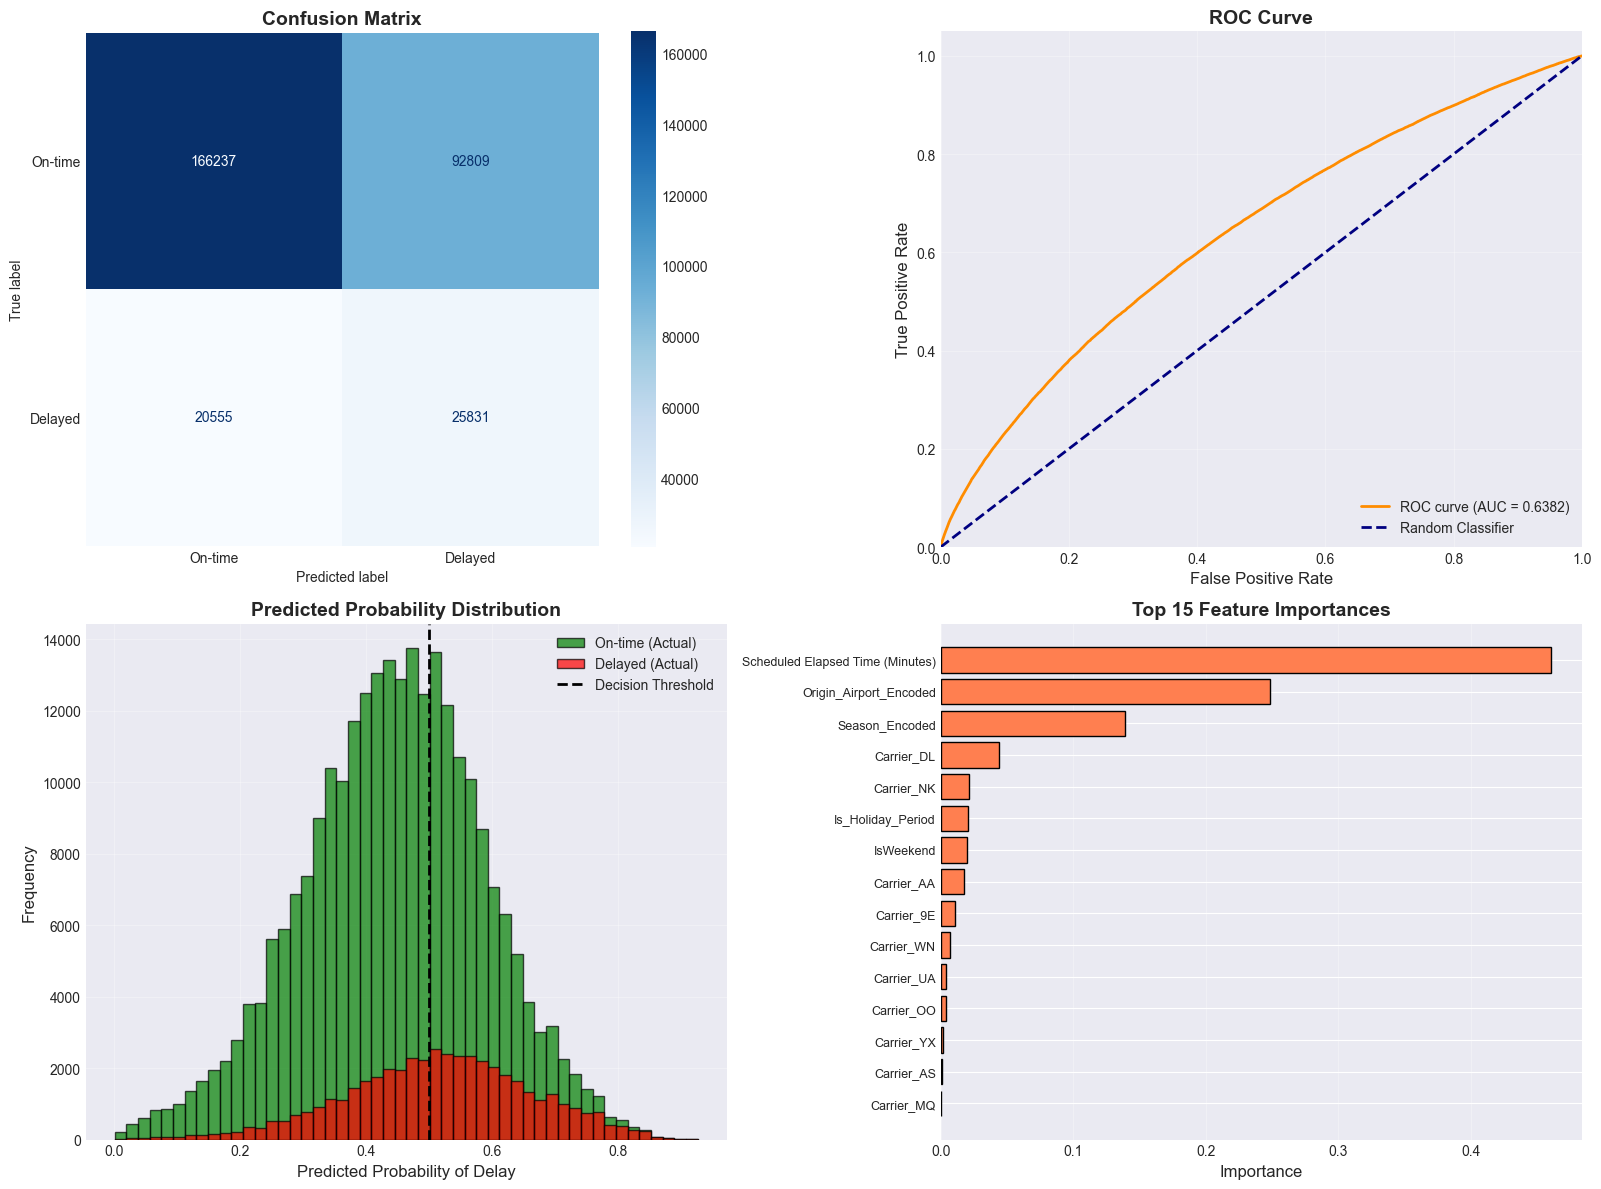

In [ ]:
# Create visualizations
from sklearn.metrics import roc_curve, auc

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Confusion Matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=clf_metrics_balanced['confusion_matrix'],
                                     display_labels=['On-time', 'Delayed'])
cm_display.plot(ax=axes[0, 0], cmap='Blues', values_format='d')
axes[0, 0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0, 0].grid(False)

# 2. ROC Curve
fpr, tpr, _ = roc_curve(y_test_clf, clf_metrics_balanced['y_test_proba'])
roc_auc = auc(fpr, tpr)
axes[0, 1].plot(fpr, tpr, color='darkorange', lw=2, 
                label=f'ROC curve (AUC = {roc_auc:.4f})')
axes[0, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[0, 1].set_xlim([0.0, 1.0])
axes[0, 1].set_ylim([0.0, 1.05])
axes[0, 1].set_xlabel('False Positive Rate', fontsize=12)
axes[0, 1].set_ylabel('True Positive Rate', fontsize=12)
axes[0, 1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[0, 1].legend(loc='lower right')
axes[0, 1].grid(alpha=0.3)

# 3. Prediction Probability Distribution
axes[1, 0].hist(clf_metrics_balanced['y_test_proba'][y_test_clf == 0], bins=50, alpha=0.7, 
                label='On-time (Actual)', color='green', edgecolor='black')
axes[1, 0].hist(clf_metrics_balanced['y_test_proba'][y_test_clf == 1], bins=50, alpha=0.7, 
                label='Delayed (Actual)', color='red', edgecolor='black')
axes[1, 0].axvline(x=0.5, color='black', linestyle='--', lw=2, label='Decision Threshold')
axes[1, 0].set_xlabel('Predicted Probability of Delay', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].set_title('Predicted Probability Distribution', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 4. Top Feature Importances
top_features_clf = importance_df_clf.head(15)
axes[1, 1].barh(range(len(top_features_clf)), top_features_clf['Importance'], 
                color='coral', edgecolor='black')
axes[1, 1].set_yticks(range(len(top_features_clf)))
axes[1, 1].set_yticklabels(top_features_clf['Feature'], fontsize=9)
axes[1, 1].set_xlabel('Importance', fontsize=12)
axes[1, 1].set_title('Top 15 Feature Importances', fontsize=14, fontweight='bold')
axes[1, 1].grid(axis='x', alpha=0.3)
axes[1, 1].invert_yaxis()

plt.tight_layout()

# Ensure save directory exists and save figure
figures_dir = Path('../results/figures')
figures_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(figures_dir / 'rf_classification_results.png', dpi=300, bbox_inches='tight')
print("Saved visualization to: ../results/figures/rf_classification_results.png")
plt.show()

### 2.6 Save Classification Model

In [ ]:
# Save the best-performing trained model (by F1 on test)
# Fall back order: tuned > balanced > original
best_model = None
best_metrics = None
best_name = None

candidates = []
try:
    candidates.append((rf_classifier_tuned, clf_metrics_tuned, 'rf_classifier_tuned.pkl'))
except NameError:
    pass

candidates.append((rf_classifier_balanced, clf_metrics_balanced, 'rf_classifier_balanced.pkl'))
candidates.append((rf_classifier, clf_metrics, 'rf_classifier.pkl'))

# Pick the model with highest test F1
best_model, best_metrics, best_filename = max(candidates, key=lambda x: x[1]['test_f1'])

model_path = f"../outputs/models/{best_filename}"
save_model(best_model, model_path)
print(f"Saved best model ({best_filename}) with Test F1={best_metrics['test_f1']:.4f}")


 Model saved to: ../outputs/models/rf_classifier_balanced.pkl
✓ Saved best model (rf_classifier_balanced.pkl) with Test F1=0.3131


---
## Part 3: Model Comparison Summary
---

In [ ]:
# Summary comparison
print("MODEL PERFORMANCE SUMMARY (Classification)")

rows = []
rows.append({
    'Model': 'Original RF',
    'Accuracy': clf_metrics['test_accuracy'],
    'Precision': clf_metrics['test_precision'],
    'Recall': clf_metrics['test_recall'],
    'F1': clf_metrics['test_f1'],
    'ROC_AUC': clf_metrics['test_roc_auc']
})
rows.append({
    'Model': 'Balanced RF',
    'Accuracy': clf_metrics_balanced['test_accuracy'],
    'Precision': clf_metrics_balanced['test_precision'],
    'Recall': clf_metrics_balanced['test_recall'],
    'F1': clf_metrics_balanced['test_f1'],
    'ROC_AUC': clf_metrics_balanced['test_roc_auc']
})
try:
    rows.append({
        'Model': 'Tuned RF',
        'Accuracy': clf_metrics_tuned['test_accuracy'],
        'Precision': clf_metrics_tuned['test_precision'],
        'Recall': clf_metrics_tuned['test_recall'],
        'F1': clf_metrics_tuned['test_f1'],
        'ROC_AUC': clf_metrics_tuned['test_roc_auc']
    })
except NameError:
    pass

summary_df = pd.DataFrame(rows)
print(summary_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

print("\n✓ Models evaluated successfully!")


MODEL PERFORMANCE SUMMARY (Classification)
      Model  Accuracy  Precision  Recall     F1  ROC_AUC
Original RF    0.8480     0.4623  0.0071 0.0141   0.6386
Balanced RF    0.6288     0.2177  0.5569 0.3131   0.6382
   Tuned RF    0.6326     0.2184  0.5502 0.3126   0.6367

✓ Models evaluated successfully!


---
## Part 4: Save Results to File
---

In [ ]:
# Save metrics to CSV (Classification models)
rows = []
rows.append({
    'Model': 'Original RF',
    'Task': 'Classification (Delay Detection)',
    'Test_Accuracy': clf_metrics['test_accuracy'],
    'Test_Precision': clf_metrics['test_precision'],
    'Test_Recall': clf_metrics['test_recall'],
    'Test_F1': clf_metrics['test_f1'],
    'Test_ROC_AUC': clf_metrics['test_roc_auc']
})
rows.append({
    'Model': 'Balanced RF',
    'Task': 'Classification (Delay Detection)',
    'Test_Accuracy': clf_metrics_balanced['test_accuracy'],
    'Test_Precision': clf_metrics_balanced['test_precision'],
    'Test_Recall': clf_metrics_balanced['test_recall'],
    'Test_F1': clf_metrics_balanced['test_f1'],
    'Test_ROC_AUC': clf_metrics_balanced['test_roc_auc']
})
try:
    rows.append({
        'Model': 'Tuned RF',
        'Task': 'Classification (Delay Detection)',
        'Test_Accuracy': clf_metrics_tuned['test_accuracy'],
        'Test_Precision': clf_metrics_tuned['test_precision'],
        'Test_Recall': clf_metrics_tuned['test_recall'],
        'Test_F1': clf_metrics_tuned['test_f1'],
        'Test_ROC_AUC': clf_metrics_tuned['test_roc_auc']
    })
except NameError:
    pass

results_summary = pd.DataFrame(rows)

results_dir = Path('../results')
results_dir.mkdir(parents=True, exist_ok=True)
results_summary.to_csv(results_dir / 'model_performance_summary.csv', index=False)

print("Results saved to: ../results/model_performance_summary.csv")
print("\nResults Summary:")
display(results_summary)

✓ Results saved to: ../results/model_performance_summary.csv

Results Summary:


,Model,Task,Test_Accuracy,Test_Precision,Test_Recall,Test_F1,Test_ROC_AUC
0,Original RF,Classification (Delay Detection),0.847953,0.462291,0.007136,0.014055,0.638628
1,Balanced RF,Classification (Delay Detection),0.628840,0.217726,0.556871,0.313054,0.638220
2,Tuned RF,Classification (Delay Detection),0.632593,0.218363,0.550188,0.312642,0.636678
